In [166]:
import os 
import pandas as pd
import numpy as np

from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.int` is a deprecated alias')

In [167]:
main_dir = "E:\MGMT patch detection\mgmt-patch-model"
os.chdir(main_dir)

Selecting patients with MGMT status available with struc features

In [168]:
df_t1_t2 = pd.read_csv("./Extracted feat combined/t1_t2_flair_t1gd.csv")
df_t1_t2.drop(['Unnamed: 0'], axis=1,inplace=True)
df_mgmt = pd.read_csv("UPENN-GBM_clinical_info_v1.0.csv")
df_mgmt.rename(columns={'ID':'SubjectID'}, inplace=True)

df_t1_t2 = df_t1_t2.merge(df_mgmt[['MGMT','SubjectID']], on='SubjectID', how='right')
df_t1_t2 = df_t1_t2.dropna(axis=0)
print("df_t1_t2.shape after combining mgmt status" + str(df_t1_t2.shape))

df_1 = df_t1_t2[df_t1_t2['MGMT'] == 'Unmethylated']
df_2 = df_t1_t2[df_t1_t2['MGMT'] == 'Methylated']
df_t1_t2 = pd.concat([df_2,df_1])
print("df_t1_t2.shape after selecting only available mgmt" + str(df_t1_t2.shape))

df_t1_t2.shape after combining mgmt status(598, 1730)
df_t1_t2.shape after selecting only available mgmt(256, 1730)


In [169]:
# Getting number of methylated and unmethylated
df_t1_t2.MGMT.value_counts()

Unmethylated    147
Methylated      109
Name: MGMT, dtype: int64

In [170]:
df_t1_t2.shape

(256, 1730)

Converting : Methylated as 1 and Unmethylated as 0 

In [171]:
df_t1_t2['MGMT']=df_t1_t2['MGMT'].apply(lambda a :1 if a=='Methylated' else 0)

### **Data Preprocessing**

### Training the features

#### Train Test Split

In [172]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df_t1_t2.drop(['MGMT','SubjectID'],axis=1), 
                                                    df_t1_t2.MGMT, test_size=0.20, 
                                                    random_state=100, 
                                                    stratify=df_t1_t2['MGMT'])
print("train size - " + str(train_x.shape))
print("test size - " + str(test_x.shape))

train size - (204, 1728)
test size - (52, 1728)


#### **Variance Threshold**

In [173]:
### Reducing features using Variance Threshold
threshold=0.3
low_var_col= [x for x in train_x.columns if train_x[x].var()<threshold]
train_x.drop(low_var_col,axis=1,inplace=True)
test_x.drop(low_var_col,axis=1,inplace=True)


#### **Correlation Technique**

In [174]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

correlated_idx=correlation(train_x,0.85)
train_x.drop(correlated_idx,axis=1,inplace=True)
test_x.drop(correlated_idx,axis=1,inplace=True)
train_x.shape


(204, 315)

#### **Feature selection Techniques**

In [175]:
# Function for rfe 
from sklearn.feature_selection import RFE,RFECV
def rfe_feature_selection(algo,X,y,cv):
  rfe=RFECV(estimator=algo,cv=cv)
  rfe.fit(X,y)
  rfe_sel_index=rfe.get_support(indices=True)
  return rfe_sel_index

In [176]:
# Function for Random Forest Classifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
def rf(x,y):
   rf = RandomForestClassifier(n_estimators=100).fit(x,y)
   return rf

In [177]:
# Principle Component Analysis

from sklearn.decomposition import PCA
def pca(n,x):
    pca=PCA(n_components=n)
    return pca.fit(x)
    

#### Features Scaling

In [178]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
x_scaled = StandardScaler().fit(train_x)
train_x_scaled = x_scaled.transform(train_x)
test_x_scaled=x_scaled.transform(test_x)

#### **Feature Importance using Buruto**

Selected features usinfg Boruta = 50

In [179]:
import xgboost as xgb
from boruta import BorutaPy
xgb_model=xgb.XGBClassifier()
feat_sel_boruta=BorutaPy(xgb_model,n_estimators='auto',verbose=0,random_state=1)
feat_sel_boruta.fit(train_x_scaled,train_y)
boruta_rank=feat_sel_boruta.ranking_

In [180]:
col_dict_rank=dict(zip(train_x.columns,boruta_rank))
boruta_sel_col=[col for col in col_dict_rank.keys() if col_dict_rank[col]<=50]
boruta_train_x=train_x[boruta_sel_col]
boruta_test_x=test_x[boruta_sel_col]

boruta_x_scaled = StandardScaler().fit(boruta_train_x)
boruta_train_x_scaled = boruta_x_scaled.transform(boruta_train_x)
boruta_test_x_scaled=boruta_x_scaled.transform(boruta_test_x)


In [181]:
from sklearn.svm import SVC
svc=SVC(kernel='poly',C=0.5)
svc.fit(boruta_train_x_scaled,train_y)
svc.score(boruta_test_x_scaled,test_y)

0.6346153846153846

0.6153846153846154


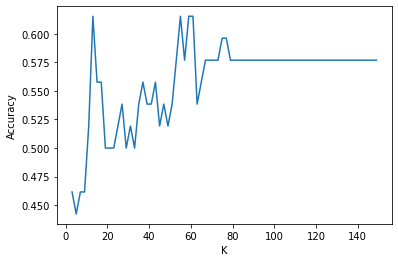

In [182]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
knn_score=[]
for k in range(3,150,2):
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(boruta_train_x_scaled,train_y)
    knn_score.append(knn.score(boruta_test_x_scaled,test_y))

# print(knn_score)
print(max(knn_score)) 
plt.plot(range(3,150,2),knn_score)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

For k=13 the accuracy is high i.e. 61%

In [183]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(boruta_train_x_scaled,train_y)
lr.score(boruta_test_x_scaled,test_y)

0.6153846153846154

### **Cross Validation**

Calling RFECV

Selected features form RFECV = 25 by using cv=15

In [184]:

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
lr=LogisticRegression()
knn=KNeighborsClassifier(n_neighbors=7)
svc=SVC(kernel='linear',C=0.7)
rfecv_feat_idx=rfe_feature_selection(svc,boruta_train_x_scaled,train_y,15) # Getting features using RFECV 
rfecv_feat_idx.shape

(25,)

selected features = 25

Used cv = 10

In [185]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
k_folds=10
skfold=StratifiedKFold(n_splits=k_folds,random_state=100,shuffle=True)
sel_train_x=np.take(boruta_train_x_scaled,rfecv_feat_idx,axis=1)
sel_test_x=np.take(boruta_test_x_scaled,rfecv_feat_idx,axis=1)
metrics=[]
for train_idx,val_idx in skfold.split(sel_train_x,train_y):
    x_train = np.take(sel_train_x,train_idx,axis=0) # This train is the train set in validation
    x_val = np.take(sel_train_x,val_idx,axis=0)
    y_train = np.take(train_y,train_idx,axis=0)
    y_val = np.take(train_y,val_idx,axis=0)
    # model_svc=SVC(kernel='poly',C=1)
    model_svc=SVC(kernel='poly',C=0.7)
    model_svc.fit(x_train,y_train)
    pred_val_y=model_svc.predict(x_val)
    pred_test_y=model_svc.predict(sel_test_x)
    metrics.append([accuracy_score(y_val,pred_val_y),
                    accuracy_score(test_y,pred_test_y)])
    
    

In [186]:
metrics

[[0.5238095238095238, 0.6153846153846154],
 [0.5238095238095238, 0.6346153846153846],
 [0.6666666666666666, 0.6153846153846154],
 [0.5238095238095238, 0.6538461538461539],
 [0.6, 0.6346153846153846],
 [0.65, 0.5961538461538461],
 [0.6, 0.6538461538461539],
 [0.55, 0.6346153846153846],
 [0.6, 0.6538461538461539],
 [0.55, 0.6538461538461539]]

get selected feature idx

In [187]:
metrics=np.array(metrics)
avg_accuracy=np.mean(metrics,axis=0)
std_accuracy=np.std(metrics,axis=0)
print("Accuracy : "+str(avg_accuracy[1])+" +/- "+str(std_accuracy[1]))

Accuracy : 0.6346153846153847 +/- 0.019230769230769232
